# Semantic smart chunking with Azure Document Intelligence

Semantic Chunking considers the relationships within the text. It divides the text into meaningful, semantically complete chunks. This approach ensures the information’s integrity during retrieval, leading to a more accurate and contextually appropriate outcome. 
 
## Note
Document Intelligence public preview releases provide early access to features that are in active development. Features, approaches, and processes may change, prior to General Availability (GA), based on user feedback.<br>
The public preview version of Document Intelligence client libraries default to REST API version 2024-07-31-preview.
Public preview version 2024-07-31-preview is currently only available in the following Azure regions. Note that the custom generative (document field extraction) model in AI Studio is only available in North Central US region:
- East US
- West US2
- West Europe
- North Central US

## Documentation

https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept-layout?view=doc-intel-4.0.0&tabs=sample-code


In [1]:
import matplotlib.pyplot as plt
import openai
import os
import pytz
import requests
import sys
import time

from dotenv import load_dotenv
from datetime import datetime
from IPython.display import Image
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader
from openai import AzureOpenAI

In [2]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")

Python version: 3.10.4 (main, Apr 28 2023, 01:29:05) [Clang 14.0.3 (clang-1403.0.22.14.1)]
OpenAI version: 1.43.1


In [3]:
# Local timezone datetime
local_tz = pytz.timezone(requests.get("https://ipinfo.io").json()["timezone"])
now = datetime.now(local_tz).strftime("%d-%b-%Y %H:%M:%S")
print(f"Local time in {local_tz}: {now}")

Local time in Asia/Seoul: 21-Sep-2024 19:09:25


## 1. Settings

In [4]:
load_dotenv(".env")

# Azure Document Intelligence
AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT: str = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT")
AZURE_DOCUMENT_INTELLIGENCE_KEY: str = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_KEY")

# Azure OpenAI
AZURE_OPENAI_API_ENDPOINT:str = os.getenv("AZURE_OPENAI_API_ENDPOINT")
AZURE_OPENAI_API_KEY:str = os.getenv("AZURE_OPENAI_API_KEY")

AZURE_API_VERSION: str = "2024-06-01"
MODEL: str = "gpt-4o-2024-08-06"

## 2.  Semantic chunking - Exemple 1

In [5]:
DOCS_DIR = "documents"

os.makedirs(DOCS_DIR, exist_ok=True)

In [6]:
document_file = os.path.join(DOCS_DIR, "APG_2022_SR.pdf")



In [7]:
!ls $document_file -lh

ls: -lh: No such file or directory
documents/APG_2022_SR.pdf


In [8]:
start = time.time()

loader = AzureAIDocumentIntelligenceLoader(
    file_path=document_file,  # File to process
    api_key=AZURE_DOCUMENT_INTELLIGENCE_KEY, # Key
    api_endpoint=AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT,  # Endpoint
    api_model="prebuilt-layout",  # Prebuilt layout of Azure Doc Intelligence
    analysis_features=["ocrHighResolution"],  # To get OCR High resolution
)

# Loading the document
print("Processing the document with Azure Document Intelligence...")
documents = loader.load()

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print("\nDone")
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Processing the document with Azure Document Intelligence...

Done
Elapsed time = 0 minutes and 52 seconds


### Extracted text

In [9]:
documents

[Document(metadata={}, page_content='# A MORE\n\n\n# BEAUTIFUL WORLD\n\n<!-- PageFooter="AMORE PACIFIC" -->\n<!-- PageFooter="2022 Amorepacific Group Sustainability Report" -->\n<!-- PageBreak -->\n\n<!-- PageHeader="Chapter 1" -->\n<!-- PageHeader="Chapter 2" -->\n<!-- PageHeader="Chapter 3" -->\n<!-- PageHeader="Chapter 4" -->\n<!-- PageHeader="Chapter 5" -->\n<!-- PageNumber="02" -->\n\nAbout\nThis Report\n\n\n## Purpose of the Report\n\nAmorepacific Group publishes a sustainability report every year\nin order to present the results of its sustainability management\nactivities. Through this report, we aim to transparently\ndisclose the company\'s environmental, social, and governance\nachievements to all stakeholders, collect various opinions, and\nreflect them in our future management activities.\n\n\n## Reporting Standards\n\nThe 2022 Amorepacific Group Sustainability Report was\nprepared in accordance with 2021 GRI (Global Reporting\nInitiative) Standards and SASB(Sustainability 

###  Semantic chunking

**Markdown** is a structured and formatted markup language and a popular input for enabling semantic chunking in RAG (Retrieval-Augmented Generation). You can use the Markdown content from the Layout model to split documents based on paragraph boundaries, create specific chunks for tables, and fine-tune your chunking strategy to improve the quality of the generated responses.

This method divides the text into chunks based on **semantic understanding**. Division boundaries are focused on sentence subject and use significant computational algorithmically complex resources. However, it has the distinct advantage of maintaining semantic consistency within each chunk. It's useful for text summarization, sentiment analysis, and document classification tasks.

https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept-retrieval-augmented-generation?view=doc-intel-4.0.0#semantic-chunking

In [10]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
    ("####", "Header 4"),
    ("#####", "Header 5"),
]

headers_to_split_on

[('#', 'Header 1'),
 ('##', 'Header 2'),
 ('###', 'Header 3'),
 ('####', 'Header 4'),
 ('#####', 'Header 5')]

In [11]:
text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
docs_string = documents[0].page_content
chunks = text_splitter.split_text(docs_string)

print(f"Number of chunks = {len(chunks)}")

Number of chunks = 322


In [12]:
chunk_size_list = []

for idx, chunk in enumerate(chunks, start=1):
    print(f"***** Chunk {idx} *****\nLength of chunk = {len(chunk.page_content)}\n")
    print(f"\033[1;34m{chunk.page_content}\033[0m\n")
    chunk_size_list.append(len(chunk.page_content))

***** Chunk 1 *****
Length of chunk = 329

<!-- PageFooter="AMORE PACIFIC" -->
<!-- PageFooter="2022 Amorepacific Group Sustainability Report" -->
<!-- PageBreak -->  
<!-- PageHeader="Chapter 1" -->
<!-- PageHeader="Chapter 2" -->
<!-- PageHeader="Chapter 3" -->
<!-- PageHeader="Chapter 4" -->
<!-- PageHeader="Chapter 5" -->
<!-- PageNumber="02" -->  
About
This Report

***** Chunk 2 *****
Length of chunk = 360

Amorepacific Group publishes a sustainability report every year
in order to present the results of its sustainability management
activities. Through this report, we aim to transparently
disclose the company's environmental, social, and governance
achievements to all stakeholders, collect various opinions, and
reflect them in our future management activities.

***** Chunk 3 *****
Length of chunk = 336

The 2022 Amorepacific Group Sustainability Report was
prepared in accordance with 2021 GRI (Global Reporting
Initiative) Standards and SASB(Sustainability Accounting
Standards Bo

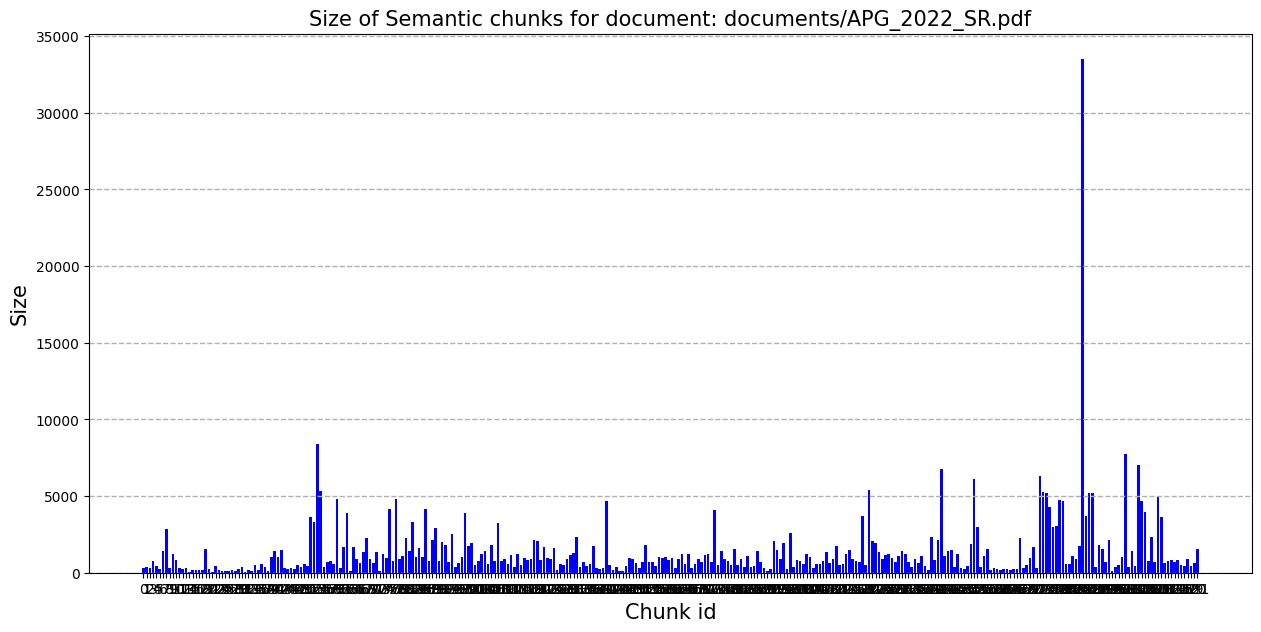

In [13]:
x = range(len(chunk_size_list))
bar_color = 'blue'

plt.figure(figsize=(15, 7))
plt.bar(x, chunk_size_list, color=bar_color)
plt.xlabel('Chunk id', size=15)
plt.ylabel('Size', size=15)
plt.title(f'Size of Semantic chunks for document: {document_file}', size=15)
plt.xticks(x)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=1)

plt.show()

### Let's try to define each chunk with Azure OpenAI GPT-4o mini

In [14]:
def gpt_4omini(text):
    """
    Gpt-4o mini model
    """
    # client = AzureOpenAI(
    #     api_key=AZURE_OPENAI_API_KEY,
    #     api_version=AZURE_API_VERSION,
    #     base_url=f"{AZURE_OPENAI_API_ENDPOINT}/openai/deployments/gpt4o-minii}",
    # )
    client = AzureOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    api_version="2024-06-01",
    base_url=f"{AZURE_OPENAI_API_ENDPOINT}/openai/deployments/gpt-4o-mini",  # Corrected model name and removed extra }
)
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": "You are an AI helpful assistant. Generate a summary of one line of this text like it was a header of a document."},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": text},
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.5,
    )

    return response

In [15]:
for idx, chunk in enumerate(chunks, start=1):
    chunk_text = chunk.page_content
    print(f"***** Chunk {idx} *****\nLength of chunk = {len(chunk_text)}\n")
    print(f"\033[1;34m{chunk_text}\033[0m\n")
    answer = gpt_4omini(chunk_text)
    print("\033[1;32m", end="")
    print(f"Chunk summary: {answer.choices[0].message.content}")
    print("\033[0m")

***** Chunk 1 *****
Length of chunk = 329

<!-- PageFooter="AMORE PACIFIC" -->
<!-- PageFooter="2022 Amorepacific Group Sustainability Report" -->
<!-- PageBreak -->  
<!-- PageHeader="Chapter 1" -->
<!-- PageHeader="Chapter 2" -->
<!-- PageHeader="Chapter 3" -->
<!-- PageHeader="Chapter 4" -->
<!-- PageHeader="Chapter 5" -->
<!-- PageNumber="02" -->  
About
This Report

Chunk summary: **Overview of the 2022 Amorepacific Group Sustainability Report**

***** Chunk 2 *****
Length of chunk = 360

Amorepacific Group publishes a sustainability report every year
in order to present the results of its sustainability management
activities. Through this report, we aim to transparently
disclose the company's environmental, social, and governance
achievements to all stakeholders, collect various opinions, and
reflect them in our future management activities.

Chunk summary: **Annual Sustainability Report: Transparency in Environmental, Social, and Governance Achievements**

***** Chunk 3 *****
Le

In [20]:
for idx, summary in enumerate(chunk_summary, start=1):
    print(f"Chunk {idx} summary: {summary}")

Chunk 1 summary: **Overview of the 2022 Amorepacific Group Sustainability Report**
Chunk 2 summary: "Amorepacific Group's Annual Sustainability Report: Transparency in Environmental, Social, and Governance Achievements"
Chunk 3 summary: 2022 Amorepacific Group Sustainability Report: Compliance with GRI and SASB Standards, Financials Based on K-IFRS.
Chunk 4 summary: **Consolidated Financial and Non-Financial Performance Reporting Scope for Amorepacific Group and Subsidiaries**


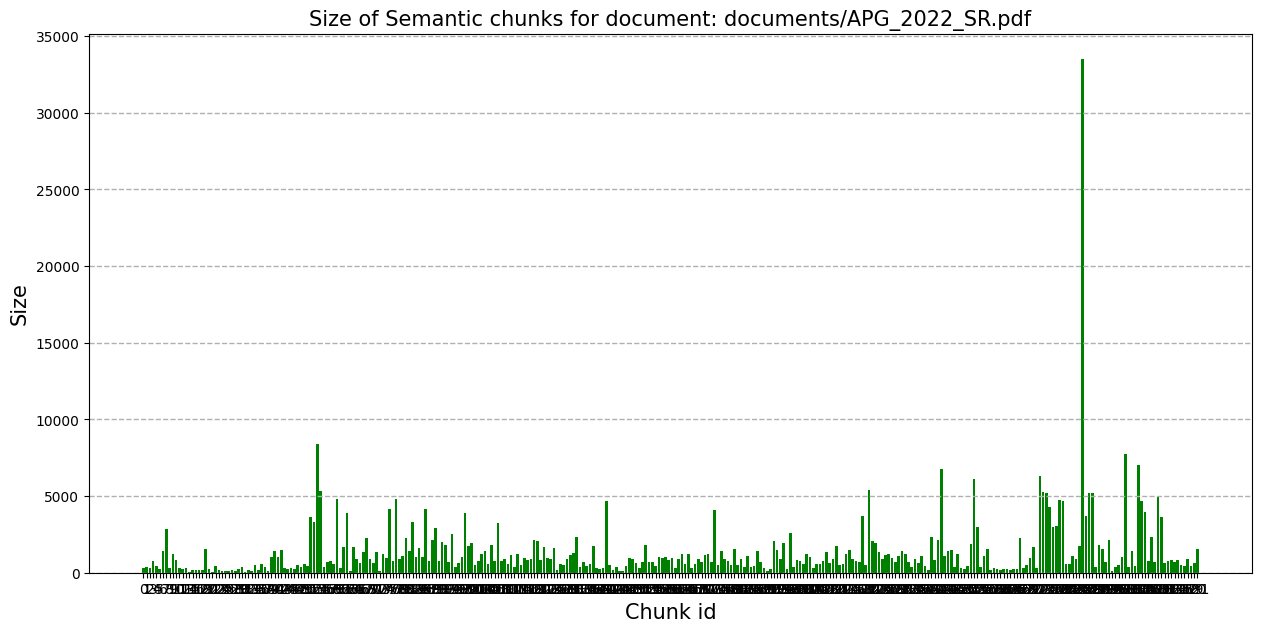

In [21]:
x = range(len(chunk_size_list))
bar_color = 'green'

plt.figure(figsize=(15, 7))
plt.bar(x, chunk_size_list, color=bar_color)
plt.xlabel('Chunk id', size=15)
plt.ylabel('Size', size=15)
plt.title(f'Size of Semantic chunks for document: {document_file}', size=15)
plt.xticks(x)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=1)

plt.show()